# LAB 4: Topic modeling

Use topic models to explore hotel reviews

Objectives:
* tokenize with MWEs using spacy
* estimate LDA topic models with tomotopy
* visualize and evaluate topic models
* apply topic models to interpretation of hotel reviews

## Analyze reviews

In [44]:
import pandas as pd
import numpy as np
from cytoolz import *
from tqdm.auto import tqdm
tqdm.pandas()

### Read in hotel review data and tokenize it

In [45]:
df = pd.read_parquet('hotels.parquet')

In [46]:
import tomotopy as tp

mdl = tp.LDAModel.load('hotel-topics.bin')

In [47]:
df[df['overall']==1]['name'].value_counts().head(20)

Hotel Pennsylvania New York                      1358
Hotel Carter                                      685
Hudson New York                                   486
Park Central                                      330
The Boston Park Plaza Hotel & Towers              238
W New York                                        233
The Roosevelt Hotel                               206
Edison Hotel Times Square                         195
Wellington Hotel                                  178
Paradise Point Resort & Spa                       169
Waldorf Astoria New York                          168
Town and Country Resort Hotel                     157
Milford Plaza Hotel                               157
Manhattan Broadway Hotel                          147
Doubletree Hotel Metropolitan - New York City     145
Grand Hyatt New York                              145
Le Parker Meridien                                144
Fort Rapids Indoor Waterpark Resort               143
New York Inn                

Pick a hotel with a lot of 1 star ratings (other than the Paradise Point Resort & Spa) and pull out all of its reviews

In [48]:
subdf = df[df['name']=='Hotel Carter']

In [49]:
subdf['overall'].value_counts()

1.0    685
3.0    258
2.0    198
4.0    153
5.0     27
Name: overall, dtype: int64

In [50]:
subdf.head()

,title,text,date_stayed,date,service,cleanliness,overall,value,location,sleep_quality,rooms,locality,name
69779,“Amazing location!”,I went to New York with my friend in october t...,October 2012,2012-12-17,5.0,3.0,4.0,5.0,5.0,4.0,3.0,New York City,Hotel Carter
69780,"“Mold in bathroom, blood stain on pillow”","Wow, Hotel Carter was so trashy all we could d...",November 2012,2012-12-16,1.0,2.0,2.0,3.0,5.0,3.0,2.0,New York City,Hotel Carter
69781,“The only good thing is the location”,I've stayed in this Hotel several times and th...,October 2012,2012-12-15,3.0,2.0,2.0,3.0,5.0,1.0,3.0,New York City,Hotel Carter
69782,“Great location but that's it”,I couldn't have asked for a better location an...,December 2012,2012-12-14,3.0,2.0,2.0,5.0,5.0,1.0,2.0,New York City,Hotel Carter
69783,"“The ownership, management and staff have no c...",We spent a wonderful but quick weekend in Manh...,December 2012,2012-12-13,1.0,1.0,1.0,1.0,4.0,2.0,1.0,New York City,Hotel Carter


Tokenize

**Make sure we are tokenizing the data that went into the constructing of the topic model in exactly the same way that we are tokenizing the data when we are applying the topic model.  If not, this could possibly create errors.

In [51]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(open('hotel-terms.txt'))

In [52]:
subdf['tokens'] = subdf['text'].progress_apply(tokenizer.tokenize)

  0%|          | 0/1321 [00:00<?, ?it/s]

<ipython-input-52-639ec7ac7f3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['tokens'] = subdf['text'].progress_apply(tokenizer.tokenize)


### Apply topic model

In [53]:
subdf['docs'] = [mdl.make_doc(words=toks) for toks in subdf['tokens']]

<ipython-input-53-4ea85f0a2328>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['docs'] = [mdl.make_doc(words=toks) for toks in subdf['tokens']]


In [54]:
topic_dist, ll = mdl.infer(subdf['docs'])

### Interpret model

What topics are associated with a review?

In [55]:
subdf['text'].iloc[0]

'I went to New York with my friend in october this year. After searching all over the internet after a cheap hotell in New York we landed on hotel carter. After reading a lot of bad reviews we were a little bit scared of what waited us when we arrived. But really, this hotel was ok. Great location, there is walking distance to everything. Subway os right around the corner and only 1 min walk from the hotel to times square. Amazing lokaction! I recomend this hotel to people who want a cheap hotel and to not care if the rooms are not big. The cleanliness in the hotel is good and the cleaning lady came every day changing towls and making the bed. I will stay here again when i come back to new york.'

In [56]:
subdf.iloc[0]

title                                          “Amazing location!”
text             I went to New York with my friend in october t...
date_stayed                                           October 2012
date                                           2012-12-17 00:00:00
service                                                        5.0
cleanliness                                                    3.0
overall                                                        4.0
value                                                          5.0
location                                                       5.0
sleep_quality                                                  4.0
rooms                                                          3.0
locality                                             New York City
name                                                  Hotel Carter
tokens           [i, went, to, new_york, with, my, friend, in, ...
docs             (i, went, to, new_york, with, my, friend, in,

In [57]:
subdf['docs'].iloc[0].get_topics(top_n=5)

[(7, 0.2249593734741211),
 (39, 0.1342429667711258),
 (10, 0.10672282427549362),
 (60, 0.10626877844333649),
 (87, 0.05311734229326248)]

In [58]:
mdl.get_topic_words(7)

[('which', 0.0248898733407259),
 ('good', 0.015538743697106838),
 ('really', 0.0124350069090724),
 ('new_york', 0.010848208330571651),
 ('clean', 0.010369175113737583),
 ('breakfast', 0.010289336554706097),
 ('only', 0.009920082055032253),
 ('its', 0.00944104790687561),
 ('staff', 0.009301329962909222),
 ('5', 0.00912169273942709)]

In [59]:
mdl.get_topic_words(39)

[('can', 0.030496977269649506),
 ('about', 0.02908889204263687),
 ('am', 0.023305894806981087),
 ('if', 0.02150377817451954),
 ('will', 0.020182611420750618),
 ('me', 0.01778944581747055),
 ('say', 0.01748233288526535),
 ('what', 0.015883026644587517),
 ('just', 0.015743955969810486),
 ('know', 0.01379697397351265)]

In [60]:
mdl.get_topic_words(10)

[('reviews', 0.0654330626130104),
 ('after', 0.0273350290954113),
 ('about', 0.026594707742333412),
 ('read', 0.023120896890759468),
 ('other', 0.02003432810306549),
 ('some', 0.018872594460844994),
 ('did', 0.016435232013463974),
 ('reading', 0.016389673575758934),
 ('booked', 0.015136823058128357),
 ('based', 0.011708569712936878)]

In [61]:
mdl.get_topic_words(60)

[('p.m.', 0.028826965019106865),
 ('after', 0.020661303773522377),
 ('until', 0.020370710641145706),
 ('a.m.', 0.02028353326022625),
 ('arrived', 0.01861262321472168),
 ('out', 0.016607532277703285),
 ('pm', 0.01640411652624607),
 ('check', 0.01627334952354431),
 ('ready', 0.01582293026149273),
 ('am', 0.01514003798365593)]

In [62]:
mdl.get_topic_words(87)

[('bed', 0.08434099704027176),
 ('sheets', 0.025379503145813942),
 ('sleep', 0.022299645468592644),
 ('pillows', 0.022151576355099678),
 ('bugs', 0.021707365289330482),
 ('night', 0.020759718492627144),
 ('mattress', 0.020463578402996063),
 ('up', 0.013356215320527554),
 ('bug', 0.010572497732937336),
 ('one', 0.009832147508859634)]

What are the most common topics?

In [63]:
#For each, we will get a list of topics
#Top 3
subdf['topics'] = [list(map(first, d.get_topics(3))) for d in subdf['docs']]

<ipython-input-63-39da8fd0ee24>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['topics'] = [list(map(first, d.get_topics(3))) for d in subdf['docs']]


In [64]:
subdf['topics']

69779     [7, 39, 10]
69780    [86, 29, 84]
69781     [19, 4, 86]
69782    [64, 87, 18]
69783     [24, 14, 4]
             ...     
71095    [41, 94, 44]
71096    [25, 47, 61]
71097    [14, 25, 44]
71098     [86, 64, 4]
71099    [55, 85, 80]
Name: topics, Length: 1321, dtype: object

Now we will aggregate across all of the reviews using a counter

In [65]:
from collections import Counter

In [66]:
topic_freq = Counter(concat(subdf['topics']))
print(f'Top Freq Words')
for t, c in topic_freq.most_common(20):
    print(f'{t:3d} {c:4d}', ', '.join(map(first, mdl.get_topic_words(t))))

Top Freq Words
 47  457 dirty, bathroom, old, carpet, like, looked, been, walls, bed, furniture
 25  374 if, your, place, want, can, or, will, get, looking, just
 14  281 no, even, staff, never, ever, rude, place, worst, their, what
 39  235 can, about, am, if, will, me, say, what, just, know
 86  175 your, if, will, can, get, up, like, or, just, go
 84  167 out, when, me, up, could, just, like, into, what, been
 87  163 bed, sheets, sleep, pillows, bugs, night, mattress, up, bug, one
  4  160 when, up, front_desk, me, us, called, out, back, told, after
 10  156 reviews, after, about, read, other, some, did, reading, booked, based
 64  123 really, nice, like, just, which, pretty, good, some, if, little
  7  113 which, good, really, new_york, clean, breakfast, only, its, staff, 5
 85  110 or, an, other, one, which, by, some, more, guests, however
 21   80 towels, housekeeping, day, when, no, left, clean, one, cleaned, them
 27   73 which, us, reception, been, when, by, booked, no, howev

Most common topics in 1 star reviews?

In [67]:
topic_freq = Counter(concat(subdf[subdf['overall']==1]['topics']))
print(f'Top Freq Words')
for t, c in topic_freq.most_common(20):
    print(f'{t:3d} {c:4d}', ', '.join(map(first, mdl.get_topic_words(t))))

Top Freq Words
 47  332 dirty, bathroom, old, carpet, like, looked, been, walls, bed, furniture
 14  239 no, even, staff, never, ever, rude, place, worst, their, what
 39  134 can, about, am, if, will, me, say, what, just, know
  4  125 when, up, front_desk, me, us, called, out, back, told, after
 84  123 out, when, me, up, could, just, like, into, what, been
 25  118 if, your, place, want, can, or, will, get, looking, just
 87  109 bed, sheets, sleep, pillows, bugs, night, mattress, up, bug, one
 86   95 your, if, will, can, get, up, like, or, just, go
 44   61 me, reservation, no, told, after, their, called, when, manager, did
 85   56 or, an, other, one, which, by, some, more, guests, however
 27   47 which, us, reception, been, when, by, booked, no, however, after
 61   44 light, door, bathroom, no, desk, bed, one, open, up, tv
 35   36 night, safe, people, area, felt, around, no, walking, security, neighborhood
 64   36 really, nice, like, just, which, pretty, good, some, if, litt

Most common topics in 5 star reviews?

In [68]:
topic_freq = Counter(concat(subdf[subdf['overall']==5]['topics']))
print(f'Top Freq Words')
for t, c in topic_freq.most_common(20):
    print(f'{t:3d} {c:4d}', ', '.join(map(first, mdl.get_topic_words(t))))

Top Freq Words
 25   13 if, your, place, want, can, or, will, get, looking, just
 80    8 times_square, nyc, location, new_york, subway, manhattan, ny, just, street, broadway
  7    7 which, good, really, new_york, clean, breakfast, only, its, staff, 5
 39    7 can, about, am, if, will, me, say, what, just, know
 67    4 shower, water, no, hot_water, hot, tv, off, out, cold, did
 10    3 reviews, after, about, read, other, some, did, reading, booked, based
 47    3 dirty, bathroom, old, carpet, like, looked, been, walls, bed, furniture
 55    3 stayed, nights, here, again, two, staff, 3, one, three, july
 86    3 your, if, will, can, get, up, like, or, just, go
 59    3 minutes, about, 10, 5, 15, only, walk, away, 20, minute_walk
 24    3 us, out, great, got, really, back, just, nice, up, night
 18    2 will, again, here, staff, great, definitely, back, stayed, clean, friendly
 68    2 been, stayed, years, times, always, has, rooms, time, here, year
 35    2 night, safe, people, area, 

### Report

Finish this notebook by writing a brief report to the hotel managers describing what you've found in the reviews of their hotel, along with some actionable advice. Use whatever data, charts, word clouds, etc. that you think will help you make your case. 

In [69]:
topic_freq = Counter(concat(subdf[subdf['overall']==1]['topics']))
print(f'Top Freq Words')
for t, c in topic_freq.most_common(20):
    print(f'{t:3d} {c:4d}', ', '.join(map(first, mdl.get_topic_words(t))))

Top Freq Words
 47  332 dirty, bathroom, old, carpet, like, looked, been, walls, bed, furniture
 14  239 no, even, staff, never, ever, rude, place, worst, their, what
 39  134 can, about, am, if, will, me, say, what, just, know
  4  125 when, up, front_desk, me, us, called, out, back, told, after
 84  123 out, when, me, up, could, just, like, into, what, been
 25  118 if, your, place, want, can, or, will, get, looking, just
 87  109 bed, sheets, sleep, pillows, bugs, night, mattress, up, bug, one
 86   95 your, if, will, can, get, up, like, or, just, go
 44   61 me, reservation, no, told, after, their, called, when, manager, did
 85   56 or, an, other, one, which, by, some, more, guests, however
 27   47 which, us, reception, been, when, by, booked, no, however, after
 61   44 light, door, bathroom, no, desk, bed, one, open, up, tv
 35   36 night, safe, people, area, felt, around, no, walking, security, neighborhood
 64   36 really, nice, like, just, which, pretty, good, some, if, litt

### Brief Report - Hotel Carter

Based on the most common topics above, it is recommended that the hotel look into/consider the following:
* Cleanliness seems to be the biggest complaint, so we recommend following up with Housekeeping on this issue... especially the carpet, bathroom, bed, and furniture.
* Customer service seems to be the 2nd highest complaint, so we recommend following up with management and staff personnel.  Perhaps, some customer service and communication training might be needed.
* Room hygiene seems to be the 3rd highest issue, so in addition to following up with Housekeeping, we also recommend hiring a pest control inspector to investigate the property for bugs, insects, etc.

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

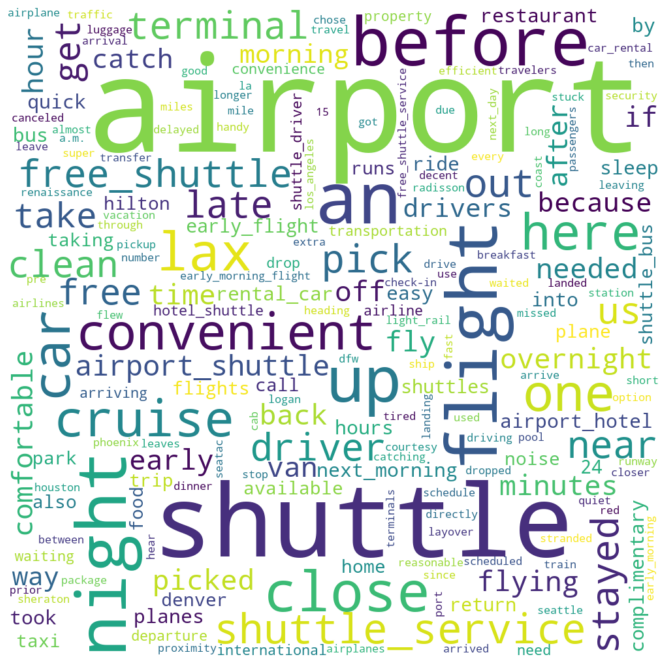

In [76]:
plt.figure(figsize=(12,12))
freqs = dict(mdl.get_topic_words(54, 200))
wc = WordCloud(width=1000,height=1000,background_color='white').generate_from_frequencies(freqs)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')
plt.show()

In [79]:
from kwic import kwic

In [80]:
kwic('airport', subdf[subdf['overall']==1.0]['text'])

69964,"st, the russian on the 'Shuttle bus' desk told us it would cost $45 to the",airport,"using their service, and a private hire would be $70 plus tolls - the bus"
69974,would still come in! And the tour desk downstairs over changed us for our,airport,"shuttle pickup. To sum things up, I would not stay here again, $130 a nigh"
70024,ell me or try to help when asked how much would a taxi charge to go to the,airport,. The room (601) was very basic but I was expenting that. What I wasnt exp
70306,ably the worst night of my entire life. After an 8 hour delay in Edinburgh,airport,followed by a 7 hour flight the first thing i wanted to do was to find our
70508,"times to this hotel and ""thanks"" to last 2 times, I'd rather sleep in JFK",airport,. First time was during September 2007. I was together with my best friend
70566,7 after travelling for nearly 15 hours. Our suitcases had been lost at the,airport,but were due to be delivered in a few hours so we wanted to go to the hote
70643,d to sleep. I got up with my 4:00 a.m. wakeup call and escaped in a cab to,airport,". I emailed some of this adventure to my friend, a long time New Yorker who"
70663,"into but it was worse than I had imagined. Also, the cost of a cab to the",airport,was cheaper than the private car that they encouraged me to reserve in the
70692,"ok where do we begin?!?! after a 14 hour flight, 2 hour wait in the",airport,"and an hour journey to the hotel, we couldnt wait to finally get to the ho"
70955,rude.. they don't care about your needs (they refused to call us a cab to,airport,"!) or complaints, the airconditioning does not work, there are no plankets,"


In [81]:
subdf.loc[69964]['text']

"Hotel Carter in New York is hands-down the most disgusting, repulsive and depressing hotel I have ever had the misfortune of staying in. Our room on the fourth floor was the sort of place you'd want to over dose in. If we'd have been slightly higher up, I might have considered jumping out of the window, rather than doing it from the fourth floor, and living to remember my time at Hotel Carter. \nThe staff are incredibly rude, starting with the egotistical, sarcastic chinese-american on the counter, and a russian who can barely speak English working the 'Shuttle Bus' counter. The pair were extremely unhelpful regarding all aspects of my stay. Before visiting our room, I visited the toilets in the lobby. Ah, no toilet roll.. that's a shame. Oh but hang on.. that was the least of my worries - one toilet was covered in urine - and I mean COVERED. All over the floor, the walls, the entire toilet.. drenched. Next cubicle.. it's even worse. faeces on the seat. HUMAN FAECES.. on the toilet se

In [82]:
subdf.loc[69974]['text']

"I was a bit skeptical when booking this hotel, reading its history and prior reviews I was hoping it would all be OK.\nWhen my husband and I travel we try to do this as cheaply as possible, with a hotel room all we want is a bed and our own bathroom...\nWe arrived at 8am and the reception lady was nice and said that our room would be ready at 11:30. We left our bags in the bag room (which cost $2 per bag), the bell boy was so sucking up for a tip it was pathetic. We just paid $2 a bag, there's you tip man! \nWhen our room was finally ready the first thing you noticed was the god awful smell. It was so bad, it smelt like mould, or wet carpet, or your nanas place a year after she had passed away! I don't know what it was but the surprises didn't stop there. The bed only had 3 pillows (2 on one side, 1 on the other) and the fluff was coming out of them. The bed was just yuck, like the cleaners didn't know what a washing machine was, or bleach for that matter. When I had a shower we had 3

### Report Continued

Based on the word cloud above and analyzing "airport," the Airport Shuttle service is mentioned a lot.  Based on these reviews, a shuttle service to the Airport is very important to Hotel Carter customers.  We would recommend providing a free service or much cheaper service.  In addition, we also recommend following up with the current service provider to ensure there is a more reliable schedule visible to customers.